In [1]:
import numpy as np
import cv2
import matplotlib
import seaborn as sn
from matplotlib import pyplot as plt
%matplotlib inline

import os
import shutil

import numpy as np
import pywt
import cv2

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

import joblib 
import json

In [3]:
face_detector=cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_dectector = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [5]:
def get_cropped_img_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:  # Check if the image was read successfully
        print(f"Warning: Could not read image at {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, 1.3, 5)
    cropped_faces = []
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_colour = img[y:y+h, x:x+w]
        eyes = eye_dectector.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            cropped_faces.append(roi_colour)
    if len(cropped_faces) > 0:
        return cropped_faces
    return None


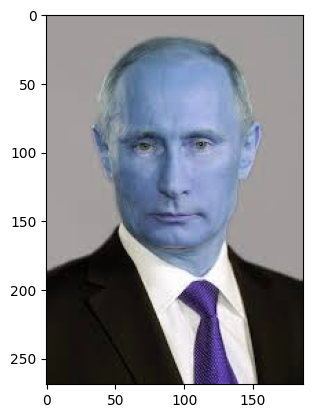

In [7]:
original_img = cv2.imread("./test_images/putin4.jpg")
plt.imshow(original_img)

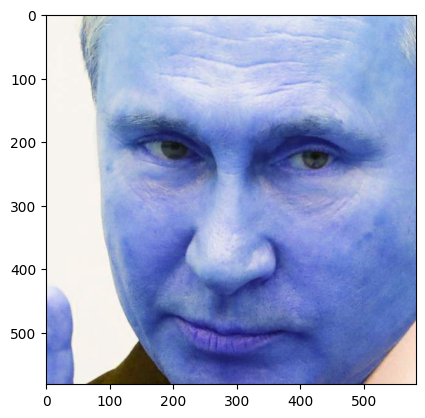

In [9]:
cropped_img = get_cropped_img_if_2_eyes("./test_images/putin2.jpg")
for img in cropped_img:
    plt.imshow(img)

In [71]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [73]:
img_dirs = []
for entry in os.scandir(path=path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [75]:
len(img_dirs)

22

In [77]:
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [79]:
cropped_image_dirs = []
political_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    political_name = img_dir.split('/')[-1]
    print(political_name)
    political_file_names_dict[political_name] = []
    
    for entry in os.scandir(path=img_dir):
        roi_colour_list = get_cropped_img_if_2_eyes(entry.path)
        if roi_colour_list is not None:
            cropped_folder = path_to_cr_data + political_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder")
            for image in roi_colour_list:
                cropped_file_name = political_name + str(count) + ".png"
                cropped_file_path = cropped_folder + '/' + cropped_file_name
                cv2.imwrite(cropped_file_path, image)
                political_file_names_dict[political_name].append(cropped_file_path)
                count+=1
print("Finished")

angela_merkel
Generating cropped images in folder
aung_san_suu_kyi
Generating cropped images in folder
benazir_bhutto
Generating cropped images in folder
benjamin_netanyahu
Generating cropped images in folder
bill_clinton
Generating cropped images in folder
dwight_d._eisenhower
Generating cropped images in folder
emmanuel_macron
Generating cropped images in folder
emperor_naruhito
Generating cropped images in folder
hosni_mubarak
Generating cropped images in folder
indira_gandhi
Generating cropped images in folder
justin_trudeau
Generating cropped images in folder
kim_jong_un
Generating cropped images in folder
king_abdullah_ii
Generating cropped images in folder
mahmoud_ahmadinejad
Generating cropped images in folder
margaret_thatcher
Generating cropped images in folder
prince_albert_ii
Generating cropped images in folder
queen_elizabeth_ii
Generating cropped images in folder
queen_rania
Generating cropped images in folder
sanna_marin
Generating cropped images in folder
tony_blair
Gen

In [81]:
def w2d(img, mode='haar', level=1):
    inArray = img
    inArray = cv2.cvtColor(inArray, cv2.COLOR_RGB2GRAY)
    inArray = np.float32(inArray)
    inArray /= 255;

    coeffs = pywt.wavedec2(inArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;

    inArray_H = pywt.waverec2(coeffs_H, mode)
    inArray_H *= 255;
    inArray_H = np.uint8(inArray_H)

    return inArray_H

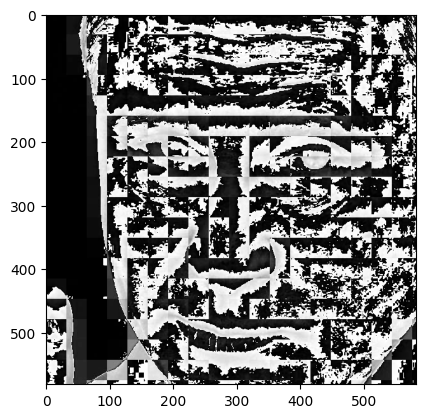

In [83]:
for image in cropped_img:
    im_har = w2d(image, 'db1', 5)
    plt.figure
    plt.imshow(im_har, cmap='gray')

In [85]:
political_file_names_dict = {}
for img_dir in cropped_image_dirs:
    political_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    political_file_names_dict[political_name] = file_list
political_file_names_dict

{'angela_merkel': ['./dataset/cropped/angela_merkel\\angela_merkel1.png',
  './dataset/cropped/angela_merkel\\angela_merkel10.png',
  './dataset/cropped/angela_merkel\\angela_merkel11.png',
  './dataset/cropped/angela_merkel\\angela_merkel12.png',
  './dataset/cropped/angela_merkel\\angela_merkel13.png',
  './dataset/cropped/angela_merkel\\angela_merkel14.png',
  './dataset/cropped/angela_merkel\\angela_merkel15.png',
  './dataset/cropped/angela_merkel\\angela_merkel16.png',
  './dataset/cropped/angela_merkel\\angela_merkel17.png',
  './dataset/cropped/angela_merkel\\angela_merkel18.png',
  './dataset/cropped/angela_merkel\\angela_merkel19.png',
  './dataset/cropped/angela_merkel\\angela_merkel2.png',
  './dataset/cropped/angela_merkel\\angela_merkel20.png',
  './dataset/cropped/angela_merkel\\angela_merkel21.png',
  './dataset/cropped/angela_merkel\\angela_merkel22.png',
  './dataset/cropped/angela_merkel\\angela_merkel23.png',
  './dataset/cropped/angela_merkel\\angela_merkel24.png',

In [87]:
class_dict = {}
count = 0
for political_name in political_file_names_dict.keys():
    class_dict[political_name] = count
    count += 1
class_dict

{'angela_merkel': 0,
 'aung_san_suu_kyi': 1,
 'benazir_bhutto': 2,
 'benjamin_netanyahu': 3,
 'bill_clinton': 4,
 'dwight_d._eisenhower': 5,
 'emmanuel_macron': 6,
 'emperor_naruhito': 7,
 'hosni_mubarak': 8,
 'indira_gandhi': 9,
 'justin_trudeau': 10,
 'kim_jong_un': 11,
 'king_abdullah_ii': 12,
 'mahmoud_ahmadinejad': 13,
 'margaret_thatcher': 14,
 'prince_albert_ii': 15,
 'queen_elizabeth_ii': 16,
 'queen_rania': 17,
 'sanna_marin': 18,
 'tony_blair': 19,
 'tsai_ing-wen': 20,
 'vladimir_putin': 21}

In [89]:
x = []
y = []

for political_name, training_files in political_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scaled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[political_name])

In [91]:
len(x[0])

4096

In [93]:
x = np.array(x).reshape(len(x),4096).astype(float)
x.shape

(842, 4096)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.5639810426540285

In [97]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.55      0.40      0.46        15
           2       0.31      0.80      0.44         5
           3       0.23      0.33      0.27         9
           4       0.29      0.67      0.40         3
           5       0.36      0.62      0.45         8
           6       0.73      0.44      0.55        18
           7       0.83      1.00      0.91        10
           8       0.75      0.33      0.46         9
           9       0.75      0.67      0.71         9
          10       0.50      0.60      0.55         5
          11       0.75      0.50      0.60         6
          12       0.71      0.42      0.53        12
          13       1.00      0.83      0.91        12
          14       0.45      0.56      0.50         9
          15       0.31      0.50      0.38         8
          16       0.50      0.22      0.31         9
          17       0.67    

In [99]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [101]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\zakir\Documents\Data_Science\political_figure_recognition\Image_Classification\model\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\zakir\Documents\Data_Science\political_figure_recognition\Image_Classification\model\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\zakir\Documents\Data_Science\political_figure_recognition\Image_Classification\model\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use

,model,best_score,best_params
0,svm,0.645032,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.309049,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.657730,{'logisticregression__C': 1}


In [103]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [105]:
best_estimators['svm'].score(X_test,y_test)

0.6208530805687204

In [107]:
best_estimators['random_forest'].score(X_test,y_test)

0.3033175355450237

In [109]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.6208530805687204

In [111]:
best_clf = best_estimators['svm']

In [113]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 9,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  0,  0],
       [ 2,  6,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  2],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1, 15,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  2,
         1,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,

Text(95.72222222222221, 0.5, 'Truth')

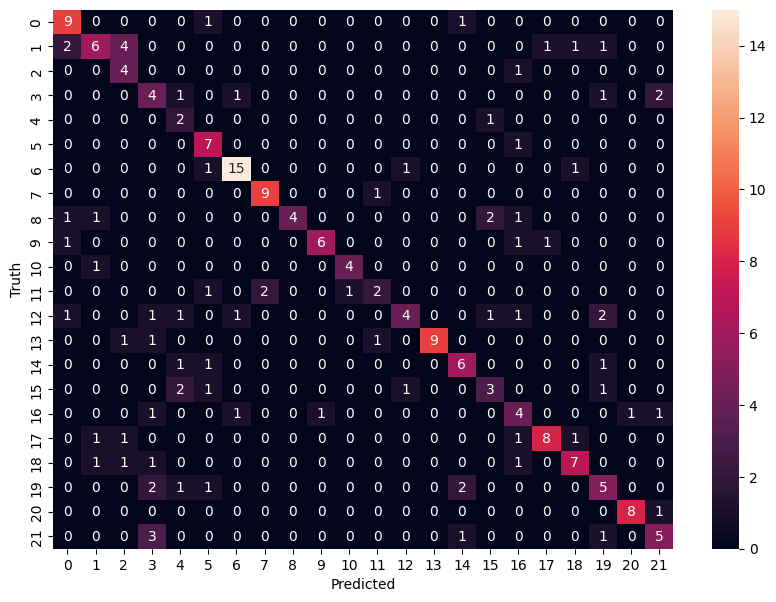

In [115]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [117]:
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [119]:
# SAVE CLASS DICTIONARY

with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))